In [1]:
# imports
from MCForecastTools import MCSimulation
#import datetime
from datetime import date
from datetime import timedelta
from time import sleep
import math
import requests
import json
import panel as pn
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from dotenv import load_dotenv
from pandas import json_normalize
    
import warnings
warnings.filterwarnings('ignore')

## Use of Python Library not been covered in Class

In [2]:
# Integrated with Twiliio for Voice and SMS
from twilio.rest import Client

# Technical Analysis Library
import ta
from ta import add_all_ta_features
from ta.utils import dropna
from ta.volatility import BollingerBands

In [3]:
# Set up Panel Plotly extension
pn.extension('plotly')

In [4]:
# Import hvplot.pandas after pn.extension
# This avoids plotly initialization failure
import hvplot.pandas

In [5]:
# Define path to datasets
dow_jones_list_path = Path('../data/rawdata/dow_jones_list.json')
sp_500_list_path = Path('../data/rawdata/sp_500_list.json')
nasdaq_100_list_path = Path('../data/rawdata/nasdaq_100_list.json')

In [6]:
# Base URL for fmp
fmp_base_url = 'https://financialmodelingprep.com/api/v3/'

In [7]:
# Read in API keys
load_dotenv('./billy/api_keys.env')
fmp_api = os.getenv("FMP_API_KEY")
account_sid = os.environ['TWILIO_SID']
auth_token = os.environ['TWILIO_AUTH_TOKEN']

In [8]:
# Connect to Twilio
client = Client(account_sid, auth_token)

In [9]:
# Read in datasets
dow_jones_list = pd.read_json (dow_jones_list_path)
sp_500_list = pd.read_json (sp_500_list_path)
nasdaq_100_list = pd.read_json (nasdaq_100_list_path)

# Add MarketCap Column
dow_jones_list['marketcap'] = 0
sp_500_list['marketcap'] = 0
nasdaq_100_list['marketcap'] = 0

## Variable Definitions

In [10]:
# Historical Data 
historical_column_names = ['date','open','high','low','close','adjClose','volume','unadjustedVolume',
                           'change','changePercent','vwap','label','changeOverTime']
ticker_headers = {'','symbol','date','open','high','low','close','adjClose','volume','unadjustedVolume',
                  'change','changePercent','vwap','label','changeOverTime'}

In [11]:

# Column Management
profile_column_names = ['symbol','price','beta','volAvg','mktCap','lastDiv','range','changes','companyName',
                        'currency','cik','isin','cusip','exchange','exchangeShortName','industry','website',
                        'description','ceo','sector','country','fullTimeEmployees','phone','address','city',
                        'state','zip','dcfDiff','dcf','image','ipoDate','defaultImage','isEtf','isActivelyTrading']

quote_column_names = ['symbol','name','price','changesPercentage','change','dayLow','dayHigh','yearHigh',
                      'yearLow','marketCap','priceAvg50','priceAvg200','volume','avgVolume','exchange','open',
                      'previousClose','eps','pe','earningsAnnouncement','sharesOutstanding','timestamp']

rating_column_names = ['symbol','ratingdate','rating','ratingScore','ratingRecommendation','ratingDetailsDCFScore',
                       'ratingDetailsDCFRecommendation','ratingDetailsROEScore','ratingDetailsROERecommendation',
                       'ratingDetailsROAScore','ratingDetailsROARecommendation','ratingDetailsDEScore',
                       'ratingDetailsDERecommendation','ratingDetailsPEScore','ratingDetailsPERecommendation',
                       'ratingDetailsPBScore','ratingDetailsPBRecommendation']

column_names = ['symbol','beta','volAvg','mktCap','lastDiv','range','changes','companyName','currency','cik','isin',
                'cusip','exchange','exchangeShortName','industry','website','description','ceo','sector','country',
                'fullTimeEmployees','phone','address','city','state','zip','dcfDiff','dcf','image','ipoDate',
                'defaultImage','isEtf','isActivelyTrading','price','changesPercentage','change','dayLow','dayHigh',
                'yearHigh','yearLow','marketCap','priceAvg50','priceAvg200','volume','avgVolume','exchange','open',
                'previousClose','eps','pe','earningsAnnouncement','sharesOutstanding','timestamp','held','totalheld',
                'ratingdate','rating','ratingScore','ratingRecommendation','ratingDetailsDCFScore',
                'ratingDetailsDCFRecommendation','ratingDetailsROEScore','ratingDetailsROERecommendation',
                'ratingDetailsROAScore','ratingDetailsROARecommendation','ratingDetailsDEScore',
                'ratingDetailsDERecommendation','ratingDetailsPEScore','ratingDetailsPERecommendation',
                'ratingDetailsPBScore','ratingDetailsPBRecommendation']

rating_names= ['symbol','companyName','exchangeShortName','industry','sector','dayLow','dayHigh','yearHigh',
               'yearLow','priceAvg50','priceAvg200','eps','pe','sharesOutstanding','held','totalheld','ratingdate',
               'rating','ratingScore','ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
               'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']

In [12]:
# Portfolio Holdings
jorge_holdings = {'AMZN':1,'BA':14,'BABA':10,'DAC':20,'FLGT':141,'PYPL':16}

william_holdings = {'T': 70,'LI': 20,'LNC': 10,'ONTO': 10,'UWMC': 100,'ABBV': 10,'ALL': 10,'GOLD': 100,'BEAM': 10,
                    'BNGO': 70,'CTXS': 10,'NIO': 40,'NVS': 11,'PCAR': 10,'PLTR': 36,'PYPL': 4,'PENN': 8,'PWOD': 45,
                    'RPTX': 10,'RKT': 25,'TER': 8,'VZ': 40}

juancarlos_holdings = {'ZM':150,'MSFT':150,'SQ':150,'BABA':150,'AAPL':150,'TSLA':150,'COST':150,'T':150,'FB':150,
                       'DIS':150,'UBER':150,'JPM':150,'TSN':150,'QCOM':150,'ALLY':150}

In [13]:
# Name to convert big numbers to human readable
millnames = ['',' Thousand',' Million',' Billion',' Trillion']

## Technical Analysis Functions

In [14]:
def add_technical_analysis(ticker):
    # Read in data to dataframe
    df = pd.read_csv(f'../data/rawdata/historical/Tickers/{ticker}_historical.csv', index_col=0)
    # Clean dataframe from nulls
    df = dropna(df)
    # Calculate Technical Analysis
    df = add_all_ta_features(df, "open", "high", "low", "close", "volume", fillna=True)
    return df

## Automate Historical data processing

In [15]:
#  Automates the process of retrieving OHLCV via API
def ticker_daily_OHLCV(ticker):
    final_df = pd.DataFrame(columns = historical_column_names)
    # Query FMP API
    fmp_historical = (f'historical-price-full/{ticker}?apikey={fmp_api}')
    fmp_historical_response = requests.get(fmp_base_url + fmp_historical)
    historical_data = fmp_historical_response.json()
    historical_columns = historical_data.get('historical')
    final_df = pd.DataFrame(historical_columns)
    final_df.insert(0, 'symbol', ticker)
    final_df.to_csv(f'../data/rawdata/historical/Tickers/{ticker}_historical.csv', header = ticker_headers)#header=False)

In [16]:
def portfolio_historical_df(dataset):
    for ticker in list(dataset['symbol']):
        name = (f'df_{ticker}')
        exec(name + " = add_all_ta(ticker)")

In [17]:
# Saves daily OHLCV for tickers in portfolio
def portfolio_daily_OHLCV(dataset):
    for ticker in list(dataset['symbol']):
        ticker_daily_OHLCV(ticker)

## Functions

In [18]:
def get_btcusdt_price():
    # Crypto API URLs
    btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=USD"
    eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=USD"

    # Fetch current BTC price
    btc_response = requests.get(btc_url)
    btc_data = btc_response.json()
    btc_price = btc_data['data']['1']['quotes']['USD']['price']
    return btc_price

In [19]:
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

In [20]:
def append_market_cap(dataset):
    df_marketcap = pd.DataFrame()
    count = 0
    for symbol in dataset['symbol']:
        # Query company info from api
        fmp_profile = (f'market-capitalization/{symbol}?apikey={fmp_api}')
        fmp_profile_response = requests.get(fmp_base_url + fmp_profile)
        data = fmp_profile_response.json()
        marketcap = data[0]['marketCap']
        dataset['marketcap'][count] = marketcap
        count += 1
        sleep(0.05)
        
    return dataset

In [21]:
def market_movers():
    mover_column_names = ['date','TotalScore','ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                          'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']
    score_column_names = ['ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                          'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore']
    fmp_gainers = (f'gainers?apikey={fmp_api}')
    fmp_losers = (f'losers?apikey={fmp_api}')
    # request data from api provider
    fmp_gainers_response = requests.get(fmp_base_url + fmp_gainers)
    fmp_losers_response = requests.get(fmp_base_url + fmp_losers)
    # Store response
    gainers_data = fmp_gainers_response.json()
    losers_data = fmp_losers_response.json()
    # Create dataframes
    output = pd.DataFrame()
    df_gainers = pd.DataFrame(gainers_data)
    df_losers = pd.DataFrame(losers_data)
    df_movers = pd.concat([df_gainers,df_losers],ignore_index=True)
    df_movers = pd.concat([df_movers,pd.DataFrame(columns = mover_column_names)])
    count = 0
    # Iterate through gainer positions
    for ticker in list(df_movers['ticker']):
        sum = 0
        # build url
        fmp_rating = (f'rating/{ticker}?apikey={fmp_api}')
        # request data from api provider
        fmp_rating_response = requests.get(fmp_base_url + fmp_rating)
        # Store response
        if str(fmp_rating_response.json())[1:-1] == '':
            count += 1
            continue
        else:
            rating_data = fmp_rating_response.json()[0]
            df_movers['price'] = df_movers['price'].astype(float)
            df_movers['changes'] = df_movers['changes'].astype(float)
            df_movers['changesPercentage'][count] = df_movers['changes'][count] / (df_movers['price'][count] - df_movers['changes'][count])
            for col in mover_column_names:
                if col == 'TotalScore':
                    for col2 in score_column_names:
                        sum += rating_data.get(col2)
                    df_movers[col][count] = sum
                else:
                    df_movers[col][count] = rating_data.get(col)
            count += 1
            
    # Clean up dataframe
    df_movers.dropna(inplace=True)
    df_movers.reset_index(inplace=True)
    df_movers.drop(['index'], axis=1, inplace=True)
    df_movers.rename(columns = {'companyName':'Name','rating':'Rating','ratingScore':'Score','ratingDetailsDCFScore':'DCF',
                                'ratingDetailsROEScore':'ROE','ratingDetailsROAScore':'ROA','ratingDetailsDEScore':'DE',
                                'ratingDetailsPEScore':'PE','ratingDetailsPBScore':'PB','changesPercentage':'Percentage'}, inplace=True)
    
    long_ideas = df_movers[['ticker','Name','price','changes','Percentage']][(df_movers['TotalScore']>23) & (df_movers['Percentage']<0)]
    short_ideas = df_movers[['ticker','Name','price','changes','Percentage']][(df_movers['TotalScore']<17) & (df_movers['Percentage']>0)]
    
    return long_ideas, short_ideas

In [22]:
def portfolio_gather_data(dataset):
    final_df = pd.DataFrame(columns = column_names)
    to_append = []

    # Iterate through positions
    for ticker in list(dataset.keys()): 
        # build url
        fmp_profile = (f'profile/{ticker}?apikey={fmp_api}')
        fmp_quote = (f'quote/{ticker}?apikey={fmp_api}')
        fmp_rating = (f'rating/{ticker}?apikey={fmp_api}')
        # request data from api provider
        fmp_profile_response = requests.get(fmp_base_url + fmp_profile)
        fmp_quote_response = requests.get(fmp_base_url + fmp_quote)
        fmp_rating_response = requests.get(fmp_base_url + fmp_rating)
        # Store response
        profile_data = fmp_profile_response.json()[0]
        quote_data = fmp_quote_response.json()[0]
        rating_data = fmp_rating_response.json()[0]
        
        # prepare profile dataframe
        profile_columns = profile_data.keys()
        to_append_profile = [profile_data[column] for column in profile_columns]
        to_append_profile.pop(1)
        
        # prepare quote dataframe
        quote_columns = quote_data.keys()
        to_append_quote = [quote_data[column] for column in quote_columns]
        to_append_quote.pop(0)
        to_append_quote.pop(0)
        
        # preapare rating dataframe
        rating_columns = rating_data.keys()
        to_append_rating = [rating_data[column] for column in rating_columns]
        to_append_rating.pop(0)
        
        # Create list
        to_append_calculations = [dataset.get(ticker), dataset.get(ticker)*to_append_quote[0]]
        
        # Concat all fields
        to_append = to_append_profile + to_append_quote + to_append_calculations + to_append_rating
        
        df_length = len(final_df)
        final_df.loc[df_length] = to_append          
        
    return final_df

In [23]:
def get_portfolio_news(list, limit):
    news_data = pd.DataFrame(columns = ['symbol','publishedDate','title','image','site','text','url'])
    # Iterate through positions
    for symbol in list: 
        # build url
        fmp_stock_news = (f'stock_news?tickers={symbol}&limit={limit}&apikey={fmp_api}')
        # request data from api provider
        fmp_stock_news_response = requests.get(fmp_base_url + fmp_stock_news)
        # Store response
        to_append = fmp_stock_news_response.json()[0]
        df_length = len(news_data)
        news_data.loc[df_length] = to_append
    news_data.drop(['image','site','text'], axis=1, inplace=True)
        
    return news_data

## Visualization Functions

In [24]:
def index_sector_plot(dataset, title):
    pie_plot = px.pie(
        dataset,
        values='marketcap',
        names='sector',
        title=title,
        width=500,
        hover_data={
        #"marketcap": millify(dataset['marketcap']),
        }
    )
    
    return pie_plot

In [25]:
def portfolio_sector_plot(dataset, title):
    pie_plot = px.pie(
        dataset,
        values='totalheld',
        names='sector',
        title=title,
        width=500,
        hover_data={
        #"marketcap": millify(dataset['marketcap']),
        }
    )
    
    return pie_plot

In [26]:
def portfolio_ratings_plot(dataset):
    rating_view = ['companyName','rating','ratingScore','ratingDetailsDCFScore','ratingDetailsROEScore','ratingDetailsROAScore',
                   'ratingDetailsDEScore','ratingDetailsPEScore','ratingDetailsPBScore','beta','eps','pe','price','priceAvg50','priceAvg200']
    
    df_rating = dataset[rating_view]
    
    df_rating.rename(columns = {'companyName':'Name','rating':'Rating','ratingScore':'Score','ratingDetailsDCFScore':'DCF',
                                'ratingDetailsROEScore':'ROE','ratingDetailsROAScore':'ROA','ratingDetailsDEScore':'DE',
                                'ratingDetailsPEScore':'PE','ratingDetailsPBScore':'PB'}, inplace=True)
    
    # Add our Total Score value and drop original data Score
    sum_column = df_rating['DCF']+df_rating['ROE']+df_rating['ROA']+df_rating['DE']+df_rating['PE']+df_rating['PB']
    df_rating['Total Score'] = sum_column
    df_rating.drop(['Score'], axis=1)

    # Rearrange columns as per Juan Carlos
    df_rating = df_rating[['Name','Rating','Total Score','DCF','ROE','ROA','DE','PE','PB','beta','eps','pe','price','priceAvg50','priceAvg200']]
    
    return df_rating

In [27]:
# JCs Distribution plot
def portfolio_distribution_plot(dataset):
    pie_plot = dataset.set_index('symbol').plot.pie(y='totalheld',
                                                    figsize=(12,12),
                                                    startangle=0,
                                                    autopct='%1.1f%%',
                                                    legend=False).figure
    return pie_plot

In [28]:
def bitcoin_simulation_plot(ax):  
    ax.plot([1,2])
    fig, ax = plt.subplots()
    plt.tight_layout()
    
    # Save the plot for future usage
    ax1.get_figure().savefig('../images/MC_Bitcoin_72_hours_sim_plot.png', bbox_inches="tight")
    
    return plt.figure(tight_layout=True)

In [29]:
def bitcoin_distribution_plot():
    # Plot probability distribution and confidence intervals
    dist_plot = MC_72_hours.plot_distribution()

    # Save the plot for future usage
    dist_plot.get_figure().savefig('../images/MC_Bitcoin_72_hours_dist_plot.png',bbox_inches='tight')
    
    fig, ax1 = plt.subplots()  
    
    return plt.figure(tight_layout=True)

## Other

In [30]:
# Import information about porfolio holding via API into Dataframe
df_jorge_holdings = portfolio_gather_data(jorge_holdings)
df_william_holdings = portfolio_gather_data(william_holdings)
df_juancarlos_holdings = portfolio_gather_data(juancarlos_holdings)

In [31]:
dow_jones_list = append_market_cap(dow_jones_list)
dow_jones_list.to_csv('../data/cleandata/dow_jones_list.csv', index=False)

In [32]:
nasdaq_100_list = append_market_cap(nasdaq_100_list)
nasdaq_100_list.to_csv('../data/cleandata/nasdaq_100_list.csv', index=False)

In [33]:
sp_500_list = append_market_cap(sp_500_list)
sp_500_list.to_csv('../data/cleandata/sp_500_list.csv', index=False)

## Part 1 - Import Indicator data from Topfolio

In [34]:
# Import data from API into Dataframe

# Define Parameters
exchange = 'Binance'
symbol = 'BTCUSDT'
indicator_type = 'orderbook'
name = '0-1%'
interval = '3600'

# Create parameterized url
base_url = "https://api.topfol.io/indicators/candle?"
today = date.today()
start_date = today - timedelta(days = 30)

parameters_url = f"startDate={start_date}&endDate={today}&exchange="+exchange+"&symbol="+symbol+"&indicator_type="+indicator_type+"&name="+name+"&interval="+interval
request_url = base_url + parameters_url

# Submit request and format output
response_data = requests.get(request_url)
pages = int(response_data.headers['page-amount'])

#Trouble shooting tool
#print (f'Number of Pages is {pages}')

new_results = True
page = 1
df_btcusdt_data = pd.DataFrame()

topfolio_api = requests.get(request_url).json()

data = topfolio_api

for page in range(2, pages+1):
    topfolio_api = requests.get(request_url + f"&page={page}").json()
    data.extend(topfolio_api)
    page += 1
    
df_btcusdt_data = json_normalize(data)


In [35]:
#Prepare Data for MCSimulation

# Convert Unix Time to iso format
df_btcusdt_data['timestamp']=(pd.to_datetime(df_btcusdt_data['timestamp'],unit='s')) 

# Set index to timestamp
df_btcusdt_data = df_btcusdt_data.set_index(['timestamp'])

# Sort Data
df_btcusdt_data = df_btcusdt_data.sort_index()

# Rename Column
df_btcusdt_data.columns = ['open','high','low','close']

df_btcusdt_data.columns = pd.MultiIndex.from_product([["BTCUSDT"], df_btcusdt_data.columns])

## Part 2 - Forecasting

### Monte Carlo Simulation

In [36]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
#Set number of simulations
num_sims = 1500

# Configure a Monte Carlo simulation to forecast
MC_72_hours = MCSimulation(
    portfolio_data = df_btcusdt_data,
    num_simulation = num_sims,
    num_trading_days = 72
)

In [37]:
# Running a Monte Carlo simulation to forecast a week cumulative returns
MC_72_hours.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6     \
0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1   1.006817  0.995134  0.997303  0.994194  0.989775  0.994354  0.995507   
2   1.009923  1.012779  1.000889  0.986881  0.987819  1.001769  1.000701   
3   1.000997  1.016458  1.001756  0.983748  0.977337  0.989374  0.990989   
4   0.998237  1.013804  1.005670  0.974875  0.960425  0.993715  0.987138   
..       ...       ...       ...       ...       ...       ...       ...   
68  0.990099  1.031824  0.991717  0.980526  0.868685  1.051085  1.025964   
69  0.995702  1.037806  0.987422  0.974093  0.870242  1.052002  1.030059   
70  0.991101  1.018486  0.989314  0.978131  0.871676  1.055258  1.036178   
71  0.992512  1.026759  0.988603  0.975733  0.866368  1.037696  1.024796   
72  0.987941  1.020155  0.975597  0.978601  0.857326  1.031163  1.038462   

        7         8         9     ...      1490      1491      1492      1493  \
0   1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1   0.996009  0.997281  0.991519  ...  1.013384  0.999146  0.996621  1.018851   
2   0.990573  0.989354  0.990409  ...  1.016028  0.992189  0.981521  1.018032   
3   1.001322  0.977417  0.986429  ...  1.024533  0.994862  0.985710  1.021860   
4   1.005452  0.975772  0.987248  ...  1.032544  0.999425  0.984740  1.029038   
..       ...       ...       ...  ...       ...       ...       ...       ...   
68  0.973832  0.924986  1.008673  ...  0.991857  1.045529  0.875060  0.995813   
69  0.960852  0.919936  0.996538  ...  0.985818  1.041007  0.867467  0.991096   
70  0.946052  0.927712  0.987259  ...  0.989021  1.050577  0.868185  1.009101   
71  0.948220  0.936924  0.980759  ...  0.995098  1.043887  0.864300  1.008606   
72  0.952186  0.923330  0.988257  ...  0.998002  1.042932  0.864215  1.009895   

        1494      1495      1496      1497      1498      1499  
0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1   1.015360  0.993516  1.004807  0.991781  0.993272  1.000599  
2   1.021518  0.999265  0.992982  0.989547  0.986853  0.984309  
3   1.012401  0.994614  0.985318  0.990087  0.978548  0.978041  
4   1.017785  0.991316  0.990827  0.978328  0.985769  0.966190  
..       ...       ...       ...       ...       ...       ...  
68  1.026104  0.921174  0.953459  1.039451  0.982520  1.063368  
69  1.032956  0.927799  0.963650  1.036830  0.983338  1.057170  
70  1.024551  0.934240  0.969158  1.021087  0.970649  1.055992  
71  1.014507  0.930788  0.981680  1.021889  0.972446  1.055804  
72  1.021633  0.929420  0.984146  1.023580  0.975078  1.062354  

[73 rows x 1500 columns]

In [38]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_72_hours.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           1500.000000
mean               0.992679
std                0.063526
min                0.769379
25%                0.949564
50%                0.989863
75%                1.033948
max                1.234449
95% CI Lower       0.874076
95% CI Upper       1.120554
Name: 72, dtype: float64


In [39]:
# Get Bitcoin Price with Function
btc_price = get_btcusdt_price()

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*btc_price,0)
ci_upper = round(tbl[9]*btc_price,0)
diff_lower = round(btc_price - ci_lower,0)
diff_upper = round(ci_upper - btc_price,0)

## Dashboard

In [40]:
dow_jones_marketcap = millify(dow_jones_list['marketcap'].sum())
nasdaq_100_marketcap = millify(nasdaq_100_list['marketcap'].sum())
sp_500_marketcap = millify(sp_500_list['marketcap'].sum())
jorge_total = millify(df_jorge_holdings['totalheld'].sum())
william_total = millify(df_william_holdings['totalheld'].sum())
juancarlos_total = millify(df_juancarlos_holdings['totalheld'].sum())

In [41]:
# Find the ideas for screener tab
long_ideas, short_ideas = market_movers()

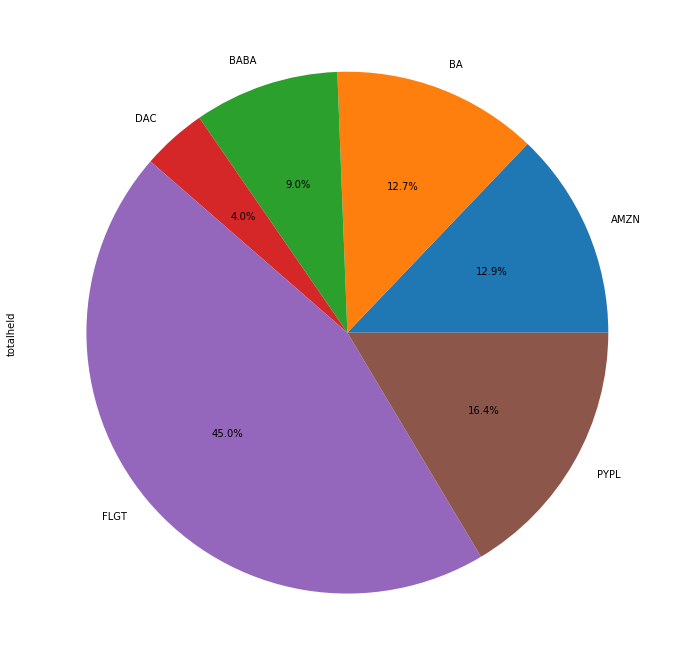

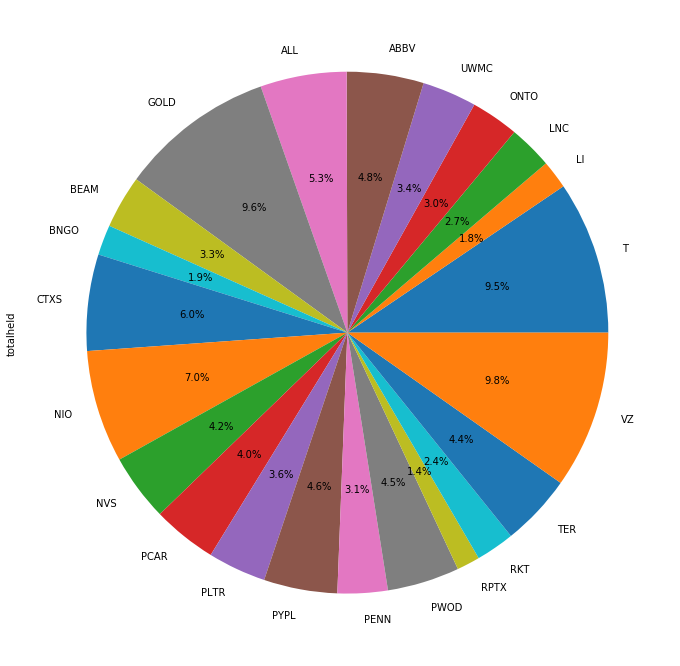

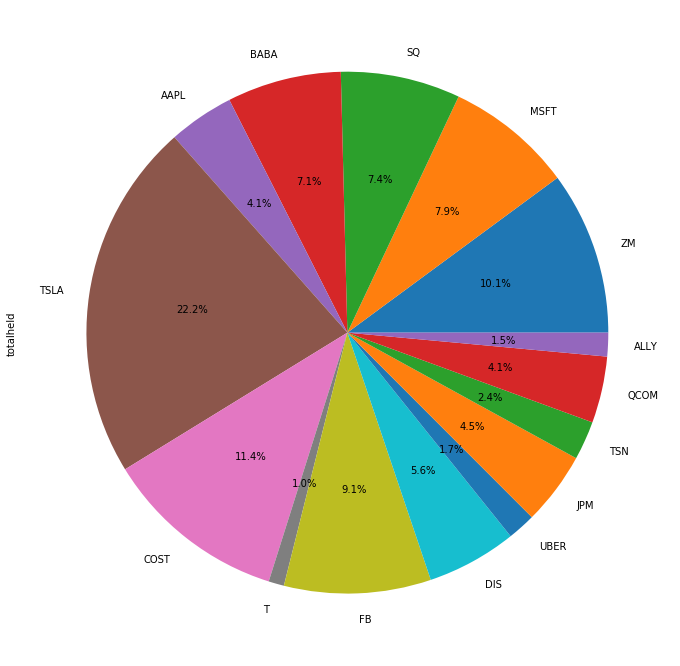

In [80]:
sector_tab = pn.Column(pn.Row(index_sector_plot(dow_jones_list, f'Dow Jones ({dow_jones_list.count()[0]} stocks / {dow_jones_marketcap})'),
                                    index_sector_plot(nasdaq_100_list, f'Nasdaq ({nasdaq_100_list.count()[0]} stocks / {nasdaq_100_marketcap})'),
                                    index_sector_plot(sp_500_list, f'S&P 500 ({sp_500_list.count()[0]} stocks / {sp_500_marketcap})')),                            
                             pn.Row(portfolio_sector_plot(df_jorge_holdings, f"Jorge's Portfolio ({len(jorge_holdings)} stocks / {jorge_total})"),
                                    portfolio_sector_plot(df_william_holdings, f"William's Portfolio ({len(william_holdings)} stocks / {william_total})"),
                                    portfolio_sector_plot(df_juancarlos_holdings, f"JC's Portfolio ({len(juancarlos_holdings)} stocks / {juancarlos_total})")))

rating_tab = pn.Column(pn.pane.Markdown("""
                                        ### Ratings
                                        |           |                        |           |                        |
                                        | ---:      | :---                   | ---:      | :---                   |
                                        | **DCF**   | - Discount Cash Flow   | **DE**    | - Debt-Equity          |
                                        | **ROE**   | - Return on Equity     | **PE**    | - Price-Earnings Ratio |
                                        | **ROA**   | - Return on Assets     | **PB**    | - Price-Book Ration    | 
                                        
                                        """),
                       pn.Tabs(('Jorge', pn.widgets.DataFrame(portfolio_ratings_plot(df_jorge_holdings),
                                                              show_index=False,
                                                              autosize_mode='fit_columns',
                                                              width=900)),
                               ('William', pn.widgets.DataFrame(portfolio_ratings_plot(df_william_holdings),
                                                                show_index=False,
                                                                autosize_mode='fit_columns',
                                                                width=900)),
                               ('JC', pn.widgets.DataFrame(portfolio_ratings_plot(df_juancarlos_holdings),
                                                                    show_index=False,
                                                                    autosize_mode='fit_columns',
                                                                    width=900))),
                       )

rebalance_text = "### Your Portfolio Investment Distribution at a glance" 

rebalance_tab = pn.Column(pn.Tabs(('Jorge', pn.Column(pn.pane.Markdown(rebalance_text),
                                                       portfolio_distribution_plot(df_jorge_holdings))),
                                   ('William', pn.Column(pn.pane.Markdown(rebalance_text), 
                                                         portfolio_distribution_plot(df_william_holdings))),
                                   ('JC', pn.Column(pn.pane.Markdown(rebalance_text), 
                                                    portfolio_distribution_plot(df_juancarlos_holdings)))))

screener_tab = pn.Column(pn.pane.Markdown("## Long Ideas"),
                         pn.widgets.DataFrame(long_ideas,show_index=False,autosize_mode='fit_columns',width=900),
                         pn.pane.Markdown("## Short Ideas"),
                         pn.widgets.DataFrame(short_ideas,show_index=False,autosize_mode='fit_columns',width=900))

news_tab = pn.Column(pn.Tabs(('Jorge',
                              pn.widgets.DataFrame(get_portfolio_news(df_jorge_holdings['symbol'],1),
                                                   show_index=False,
                                                   autosize_mode='fit_columns',
                                                   width=900)),
                             ('William',
                              pn.widgets.DataFrame(get_portfolio_news(df_william_holdings['symbol'],1),
                                                   show_index=False,
                                                   autosize_mode='fit_columns',
                                                   width=900)),
                             ('JC',
                              pn.widgets.DataFrame(get_portfolio_news(df_juancarlos_holdings['symbol'],1),
                                                   show_index=False,
                                                   autosize_mode='fit_columns',
                                                   width=900))))

bitcoin_forecast_tab = pn.Column(pn.pane.Markdown('## BTCUSDT 72-hour Price Prediction range'),
                                 pn.pane.Markdown(f"The current price is **${btc_price}** and has a **95%** chance that it will be within the range of " \
                                 f"**${ci_lower}** and **${ci_upper}**"),
                                 pn.Tabs(
                                     ('Simulation',
                                      pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/PA_btc_sim_plot.png?raw=true)")),
                                     ('Distribution',
                                      pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/PA_btc_distribution_plot.png?raw=true)"))))
    
#    width=700)

technical_tab = pn.Column(pn.pane.Markdown("## Technical Analysis"),
                          pn.Tabs(('Daily', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_daily_return.png?raw=true)")),
                                  ('Cumulative', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_cumulative_returns.png?raw=true)")),
                                  ('Box Plot', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_box_plot.png?raw=true)")),
                                  ('SPY', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_spy_daily_returns.png?raw=true)")),
                                  ('LR', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_log_return.png?raw=true)")),
                                  ('MA', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_moving_avg.png?raw=true)")),
                                  ('MACD', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_macd.png?raw=true)")),
                                  ('RSI', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_rsi.png?raw=true)")),
                                  ('OBV', 
                                   pn.pane.Markdown("![](https://github.com/wchance/project1/blob/main/images/Presentation/TA_obv.png?raw=true)")),
                                 ))
                    

    


Column
    [0] Markdown(str, width=700)
    [1] Tabs
        [0] Column
            [0] Row
                [0] Plotly(Figure)
                [1] Plotly(Figure)
                [2] Plotly(Figure)
            [1] Row
                [0] Plotly(Figure)
                [1] Plotly(Figure)
                [2] Plotly(Figure)
        [1] Column
            [0] Tabs
                [0] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
                [1] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
                [2] Column
                    [0] Markdown(str)
                    [1] Matplotlib(Figure)
        [2] Column
            [0] Markdown(str)
            [1] Tabs
                [0] DataFrame(autosize_mode='fit_columns', show_index=False, value=              ..., width=900)
                [1] DataFrame(autosize_mode='fit_columns', show_index=False, value=                          ..., width=900)
                [2] DataFrame(autosize_mode='fit_columns', show_index=False, value=              ..., width=900)
        [3] Column
            [0] Markdown(str)
            [1] DataFrame(autosize_mode='fit_columns', show_index=False, value=   ticker     ..., width=900)
            [2] Markdown(str)
            [3] DataFrame(autosize_mode='fit_columns', show_index=False, value=Empty DataFrame
Columns: [..., width=900)
        [4] Column
            [0] Tabs
                [0] DataFrame(autosize_mode='fit_columns', show_index=False, value=  symbol        publishedD..., width=900)
                [1] DataFrame(autosize_mode='fit_columns', show_index=False, value=   symbol        published..., width=900)
                [2] DataFrame(autosize_mode='fit_columns', show_index=False, value=   symbol        published..., width=900)
        [5] Column
            [0] Markdown(str)
            [1] Markdown(str)
            [2] Tabs
                [0] Markdown(str)
                [1] Markdown(str)
        [6] Column
            [0] Markdown(str)
            [1] Tabs
                [0] Markdown(str)
                [1] Markdown(str)
                [2] Markdown(str)
                [3] Markdown(str)
                [4] Markdown(str)
                [5] Markdown(str)
                [6] Markdown(str)
                [7] Markdown(str)
                [8] Markdown(str)
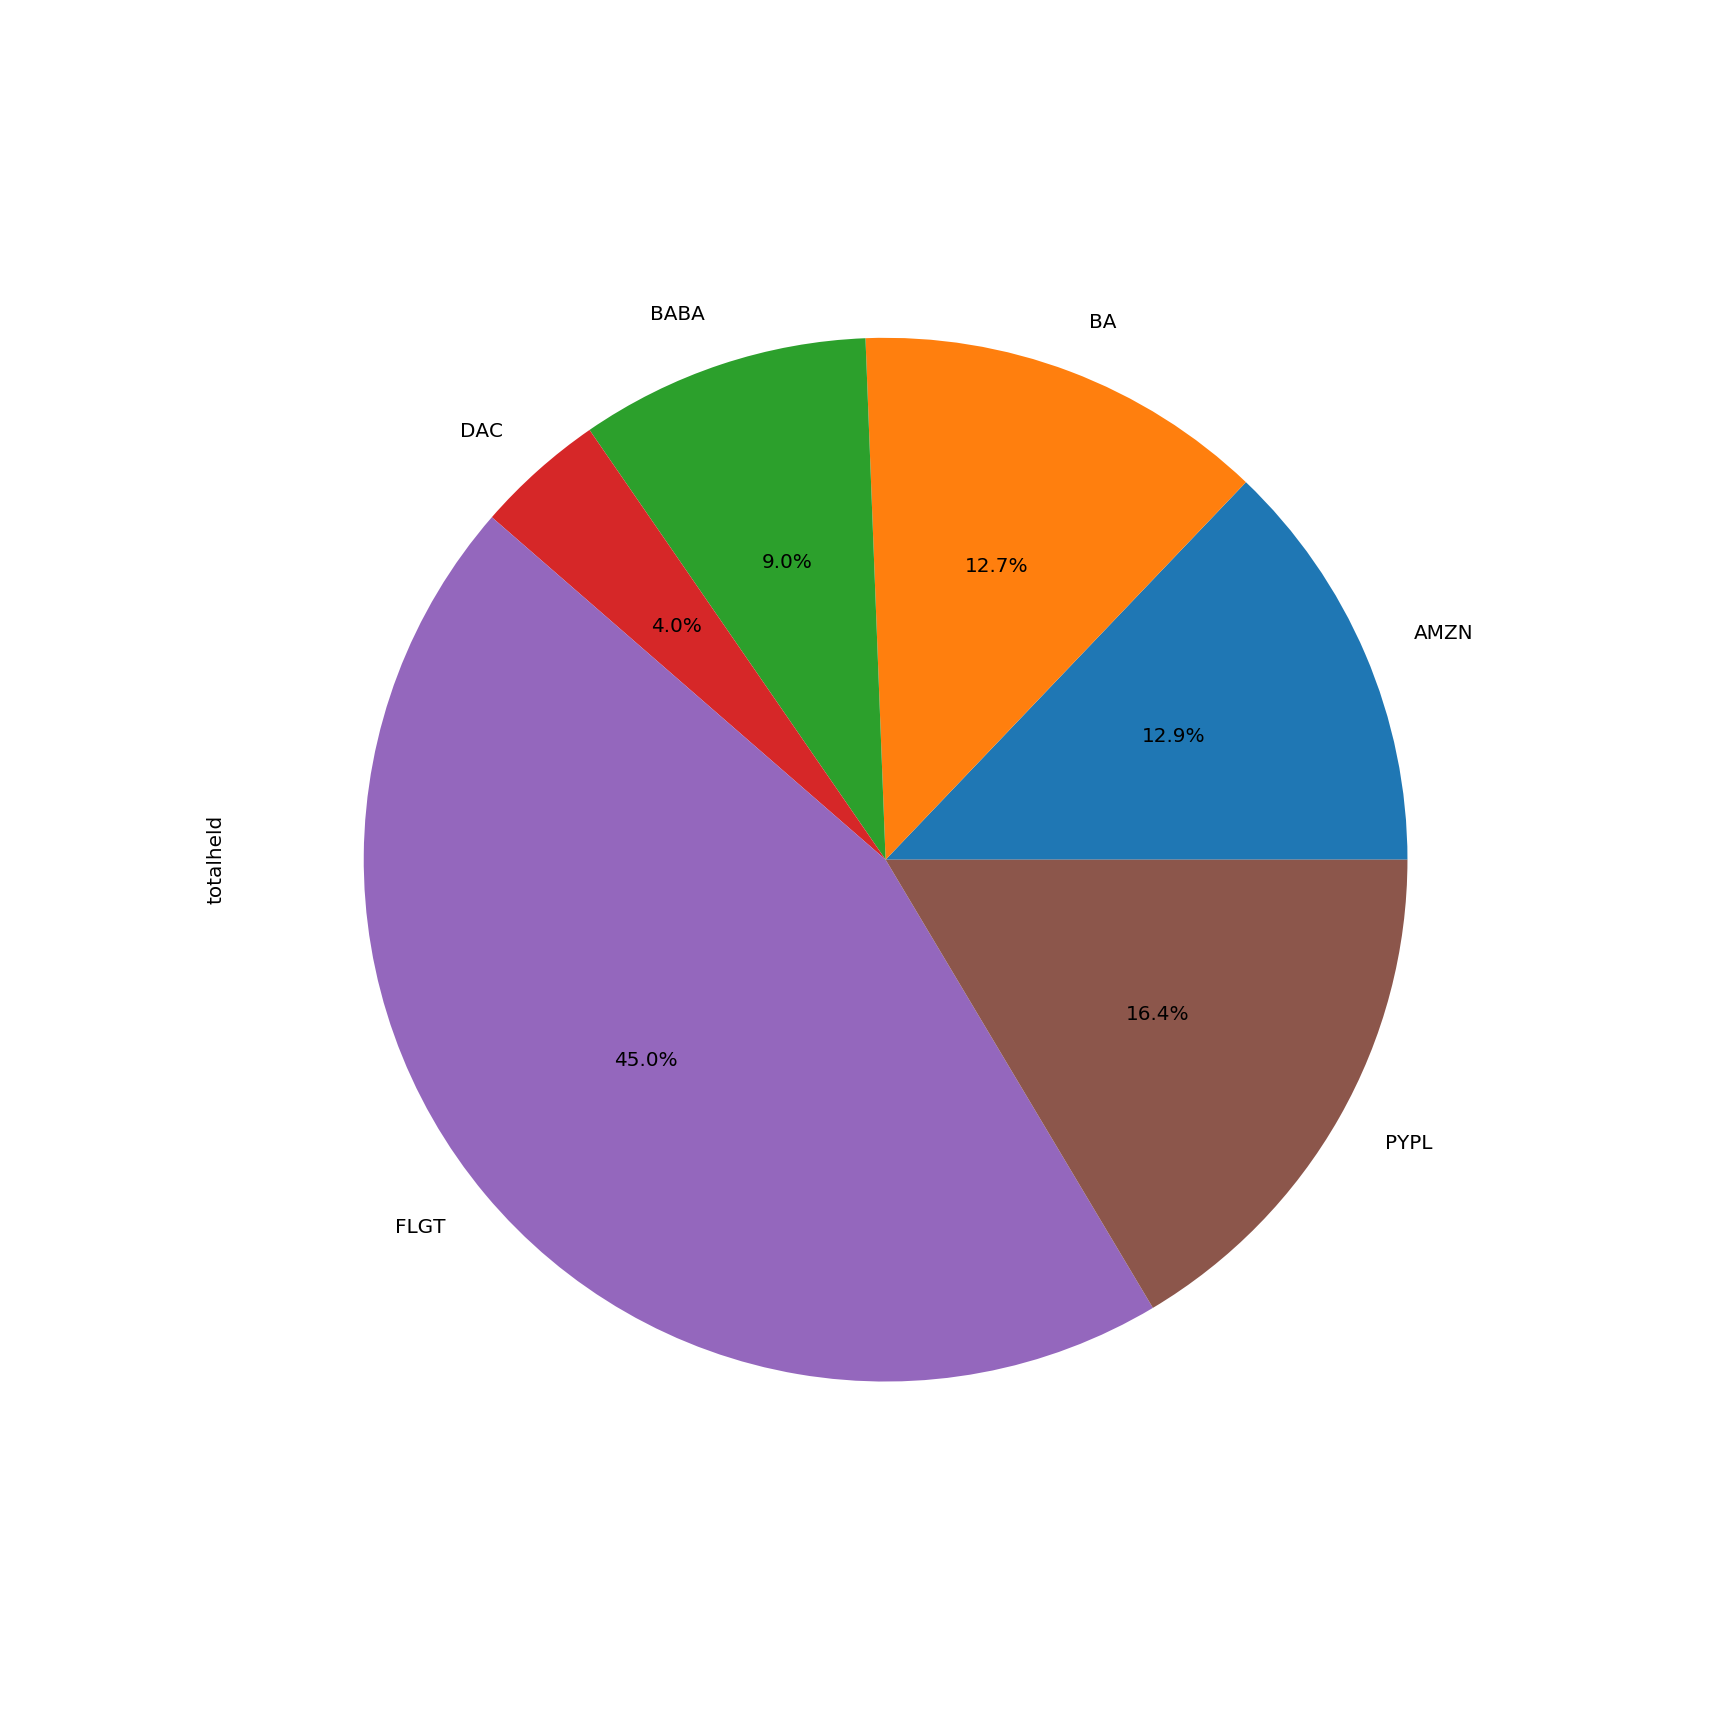
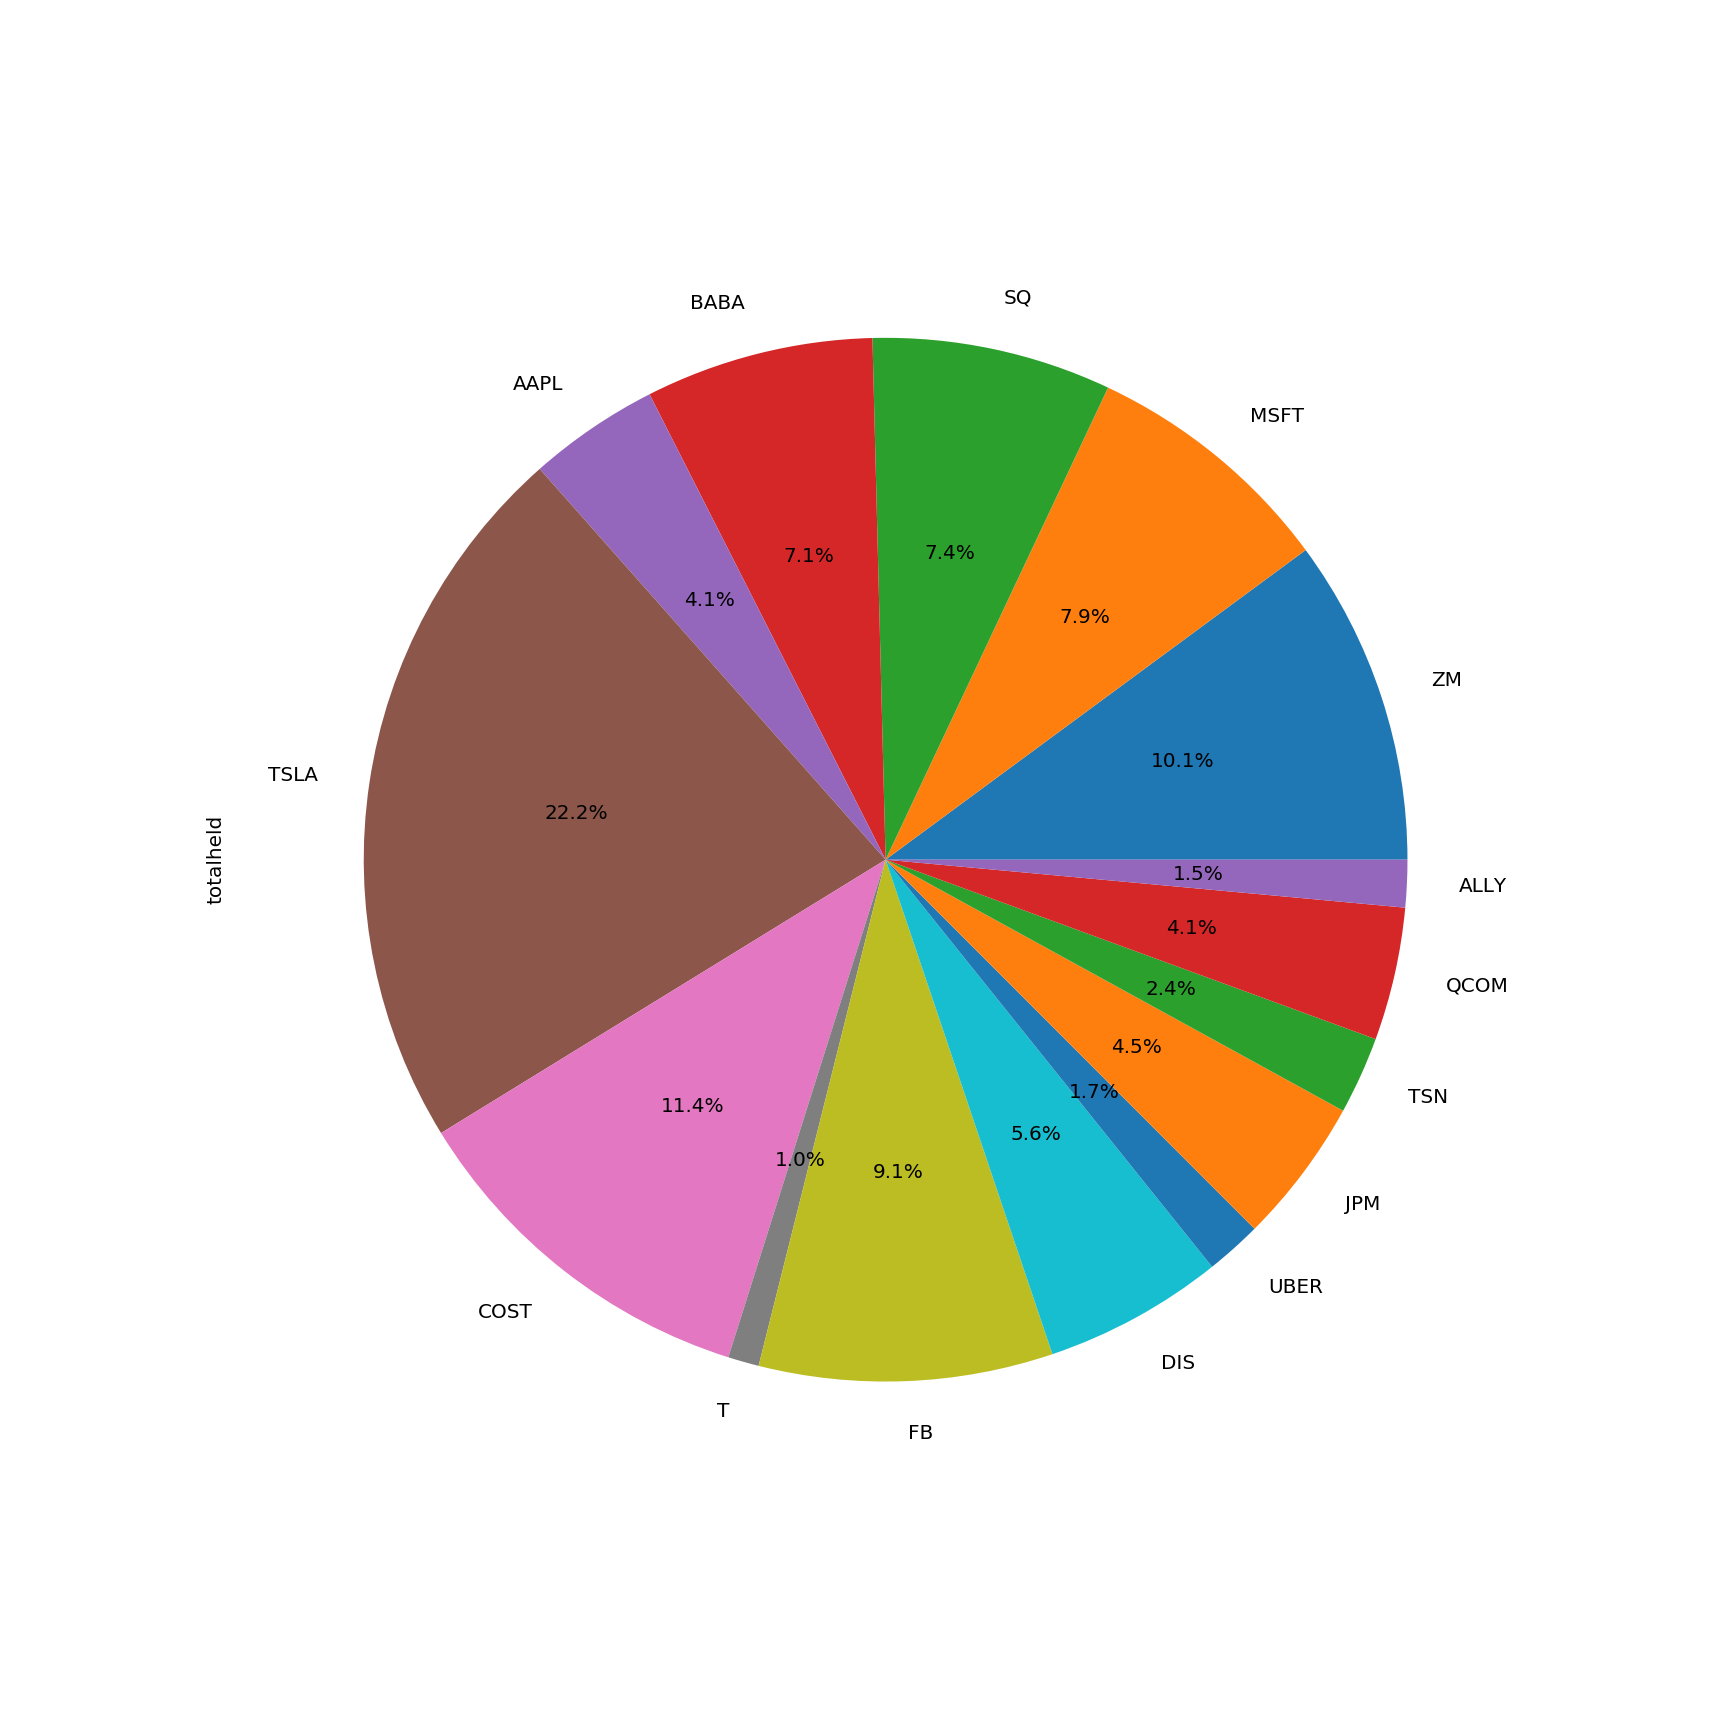
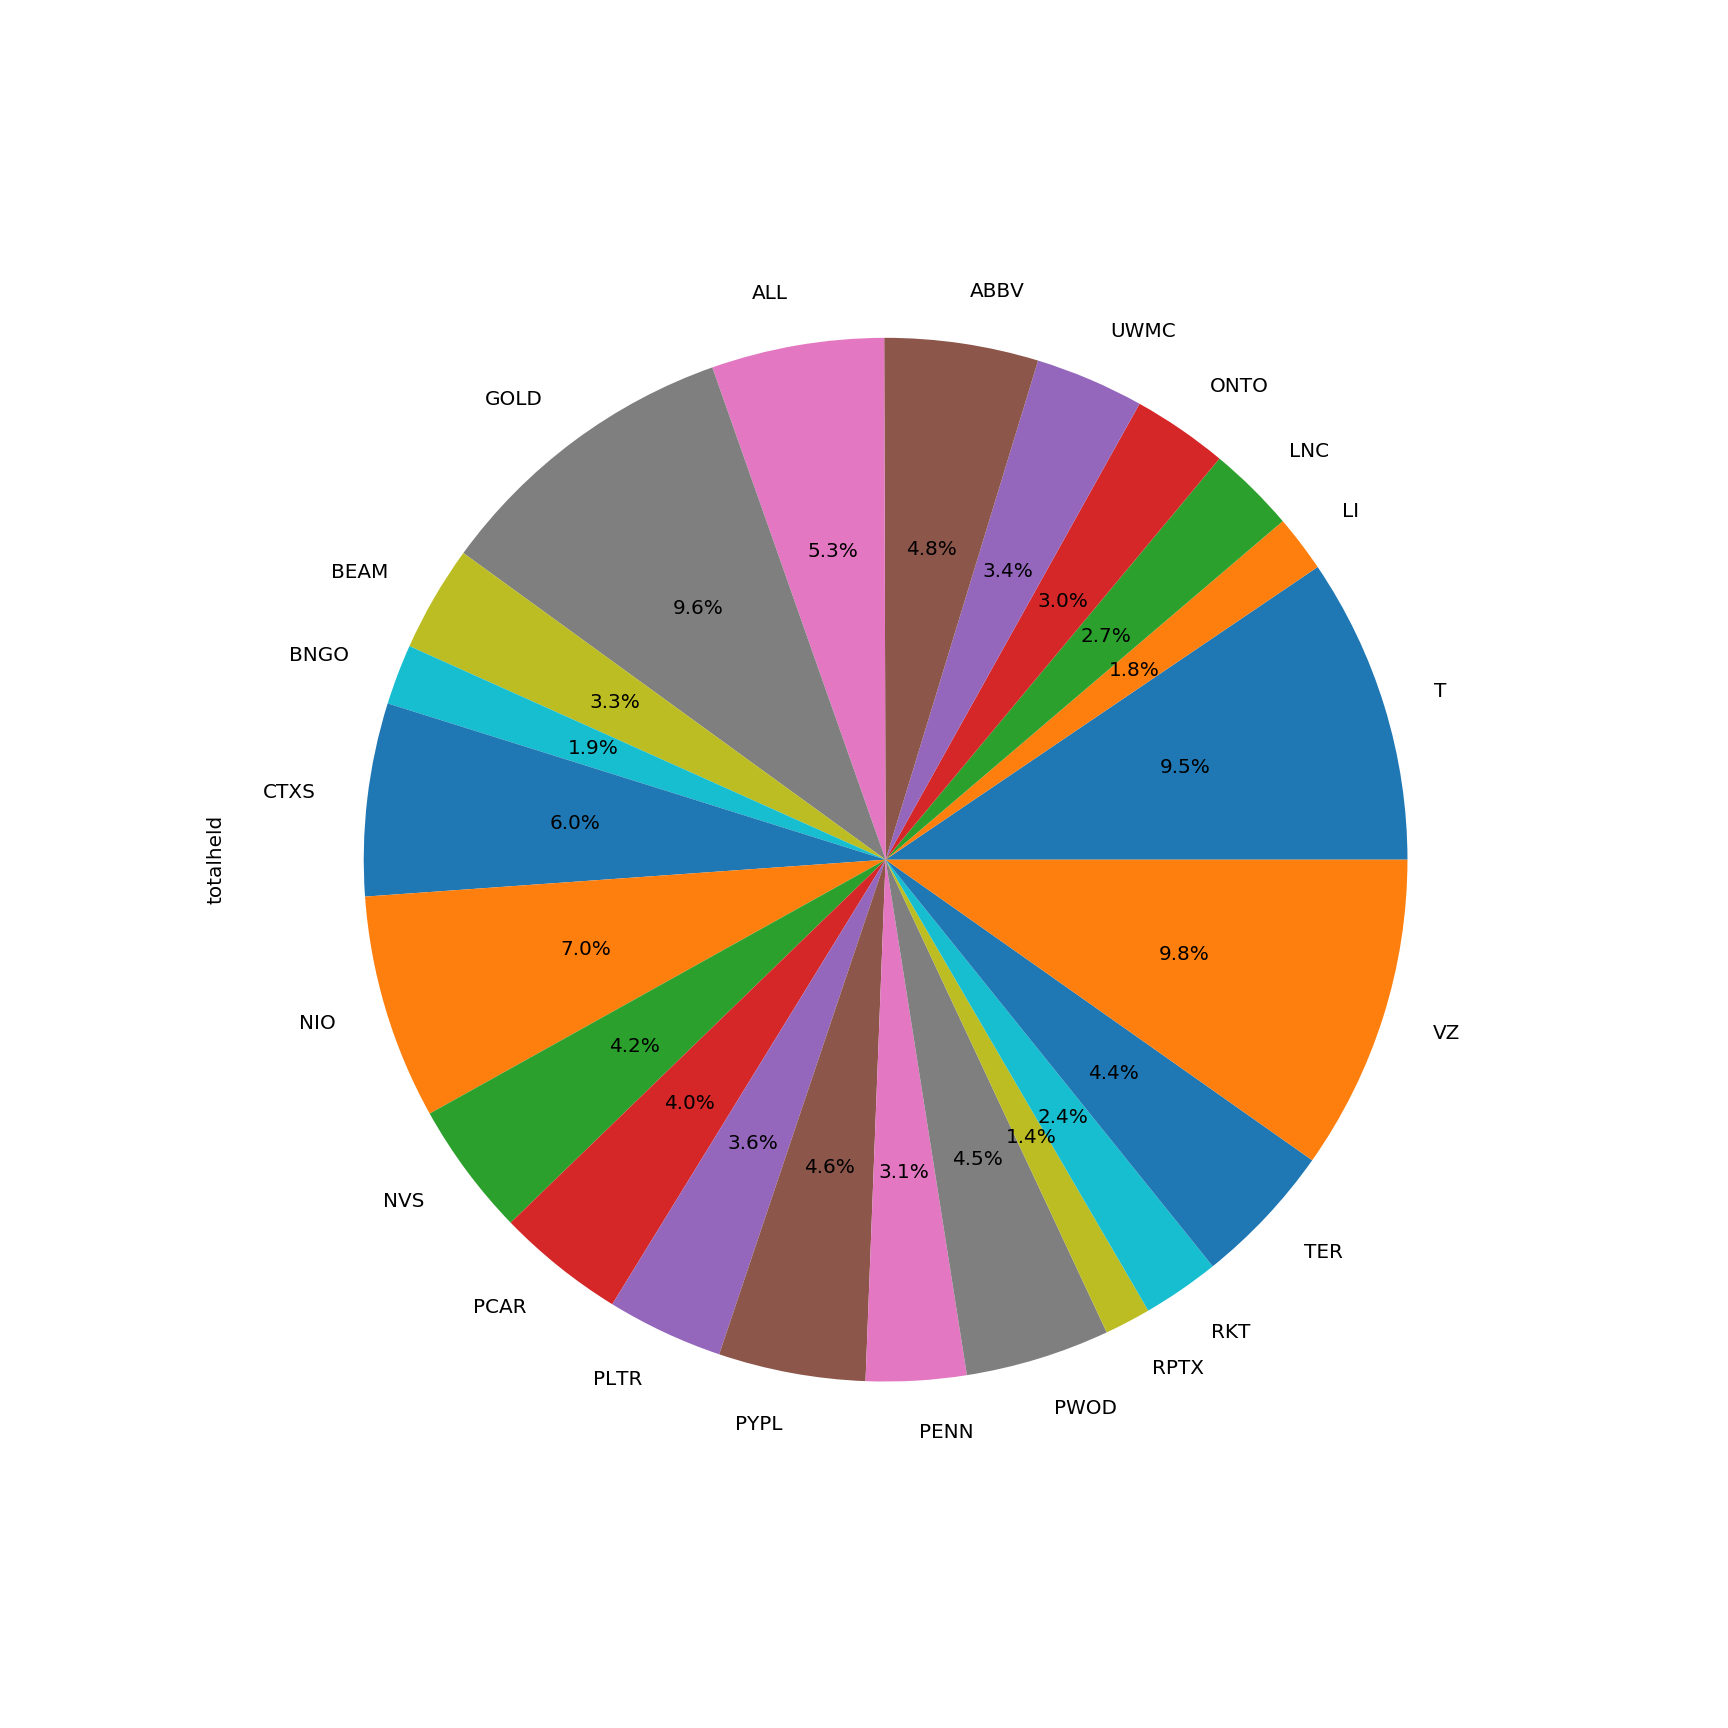

In [81]:
# Create a Title for the Dashboard
dashboard_title = '# Portfolio Analyzer'

# Create a tab layout for the dashboard
index_analysis_dashboard = pn.Column(pn.pane.Markdown(dashboard_title, width=700),pn.Tabs(('Sector', sector_tab),
                                                                                          ('Rebalance', rebalance_tab),
                                                                                          ('Ratings', rating_tab),
                                                                                          ('Screener', screener_tab),
                                                                                          ('News', news_tab),
                                                                                          ('Bitcoin Forecast', bitcoin_forecast_tab),
                                                                                          ('Technical Analysis', technical_tab)))                                                                        
                                                                                          
                                       
# Create the dashboard
index_analysis_dashboard.servable()

In [46]:
message = client.messages \
                .create(
                     body=(f"BTC ${btc_price} Predicted 72 hour range ${ci_lower} and ${ci_upper}"),
                     from_='+19032877979',
                     to='+13057257577'
                 )

print(message.sid)

SMd5e1aaaf73324f15bc1f2d0be7895564
